In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def plot(t_loss, v_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(t_loss, label='Training Loss', color='blue', marker='o')
    plt.plot(v_loss, label='Validation Loss', color='red', marker='x')

    # Add labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()

In [ ]:
transform = transforms.Compose([  
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.514, 0.528, 0.506], std=[0.191, 0.189, 0.237])
])
dataset = datasets.ImageFolder(root='./dataset', transform=transform)
print("Classes found:", dataset.classes)
np.random.seed(42)  
indices = list(range(len(dataset)))

# Get the labels for stratified split
labels = [dataset.targets[i] for i in indices]

# Perform a stratified split (80% train, 20% validation set, 20% test)
train_indices, val_indices = train_test_split(indices, test_size=0.2, stratify=labels)
#train_labels = [dataset.targets[i] for i in train_indices]
##train_indices, val_indices = train_test_split(train_indices, test_size=0.25 ,stratify=train_labels)

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

print(len(dataset))

Classes found: ['AR', 'AT', 'BE', 'BR', 'CA', 'CH', 'CL', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'IE', 'IL', 'IN', 'JP', 'KR', 'MX', 'NL', 'NO', 'NZ', 'PL', 'PT', 'SE', 'TH', 'UK', 'US', 'ZA']
30000


#calulating mean and std
train_subset = Subset(dataset, train_indices)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)

mean = torch.zeros(3).to(device)  
std = torch.zeros(3).to(device)
total_images = 0

for inputs, _ in train_loader:
    inputs = inputs.to(device)
    batch_samples = inputs.size(0)  
    inputs = inputs.view(batch_samples, inputs.size(1), -1)  
    
    mean += inputs.mean(dim=2).sum(dim=0)  
    std += inputs.std(dim=2).sum(dim=0)  
    total_images += batch_samples
mean /= total_images
std /= total_images

print(f"Mean: {mean.cpu().numpy()}")
print(f"Standard Deviation: {std.cpu().numpy()}")

Mean: [0.5138129  0.5282723  0.50622165]
Standard Deviation: [0.19146287 0.18862008 0.2368328 ]

In [ ]:

class CNN_MLP(nn.Module):
    def __init__(self, num_classes=30, dropout_rate=0.5):
        super(CNN_MLP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(32 * 64 * 64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [5]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)

    best_train_loss = 100
    count = 0
    best_val_accuracy = 0  
    best_model_state = None 

    train_loss = []
    val_loss = [] 

    
    for epoch in range(num_epochs):
        model.train()  
        running_train_loss = 0.0
        running_corrects_train = 0
        total_train = 0

        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  
            loss = criterion(outputs, labels)  

            
            loss.backward()
            optimizer.step()

            
            running_train_loss += loss.item() * inputs.size(0)
            running_corrects_train += torch.sum(preds == labels).item()
            total_train += labels.size(0)

        
        epoch_train_loss = running_train_loss / total_train
        epoch_train_accuracy = running_corrects_train / total_train
       
        model.eval()  
        running_val_loss = 0.0
        running_corrects_val = 0
        total_val = 0

        with torch.no_grad():  
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)  
                loss = criterion(outputs, labels)  

                running_val_loss += loss.item() * inputs.size(0)
                running_corrects_val += torch.sum(preds == labels).item()
                total_val += labels.size(0)

        epoch_val_loss = running_val_loss / total_val
        epoch_val_accuracy = running_corrects_val / total_val

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}")
        print(f"  Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")
        train_loss.append(epoch_train_loss)
        val_loss.append(epoch_val_loss)

        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            best_model_state = model.state_dict()  # Save model parameters

        if best_train_loss > epoch_train_loss:
            best_train_loss = epoch_train_loss
            count = 0
        else:
            count += 1

        if count == 3:
            print("Early stopping!")
            break

    # Load the best model weights (based on validation accuracy)
    model.load_state_dict(best_model_state)

    return model , train_loss , val_loss

In [6]:
model = CNN_MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
model.to(device)

trained_model , train_loss , val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device=device)


Epoch 1/100:
  Training Loss: 3.6178, Training Accuracy: 0.1243
  Validation Loss: 3.2245, Validation Accuracy: 0.1273
Epoch 2/100:
  Training Loss: 2.7113, Training Accuracy: 0.2349
  Validation Loss: 2.9879, Validation Accuracy: 0.2040
Epoch 3/100:
  Training Loss: 2.3717, Training Accuracy: 0.3225
  Validation Loss: 2.7887, Validation Accuracy: 0.2385
Epoch 4/100:
  Training Loss: 1.9866, Training Accuracy: 0.4268
  Validation Loss: 2.6622, Validation Accuracy: 0.2630
Epoch 5/100:
  Training Loss: 1.5737, Training Accuracy: 0.5372
  Validation Loss: 2.5653, Validation Accuracy: 0.2803
Epoch 6/100:
  Training Loss: 1.2015, Training Accuracy: 0.6393
  Validation Loss: 2.6358, Validation Accuracy: 0.2673
Epoch 7/100:
  Training Loss: 0.9061, Training Accuracy: 0.7221
  Validation Loss: 2.7065, Validation Accuracy: 0.2735
Epoch 8/100:
  Training Loss: 0.7175, Training Accuracy: 0.7793
  Validation Loss: 2.7548, Validation Accuracy: 0.2778
Epoch 9/100:
  Training Loss: 0.5848, Training A

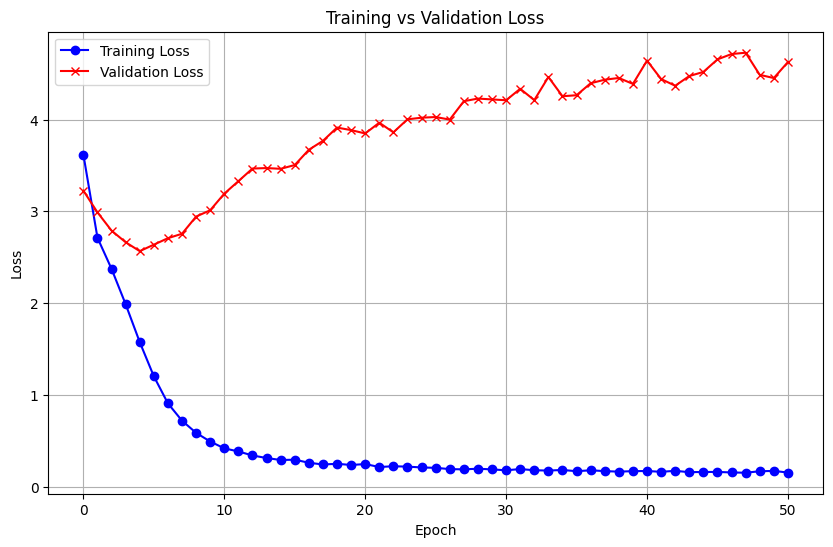

In [7]:
plot(train_loss,val_loss)

Epoch 1/100:
  Training Loss: 3.1392, Training Accuracy: 0.1377
  Validation Loss: 3.1268, Validation Accuracy: 0.1573
Epoch 2/100:
  Training Loss: 2.7370, Training Accuracy: 0.2275
  Validation Loss: 3.0068, Validation Accuracy: 0.1780
Epoch 3/100:
  Training Loss: 2.5261, Training Accuracy: 0.2854
  Validation Loss: 2.8613, Validation Accuracy: 0.2185
Epoch 4/100:
  Training Loss: 2.3188, Training Accuracy: 0.3454
  Validation Loss: 2.7416, Validation Accuracy: 0.2482
Epoch 5/100:
  Training Loss: 2.1015, Training Accuracy: 0.4006
  Validation Loss: 2.6736, Validation Accuracy: 0.2618
Epoch 6/100:
  Training Loss: 1.8636, Training Accuracy: 0.4720
  Validation Loss: 2.6005, Validation Accuracy: 0.2695
Epoch 7/100:
  Training Loss: 1.6312, Training Accuracy: 0.5338
  Validation Loss: 2.5641, Validation Accuracy: 0.2797
Epoch 8/100:
  Training Loss: 1.4215, Training Accuracy: 0.5932
  Validation Loss: 2.6084, Validation Accuracy: 0.2718
Epoch 9/100:
  Training Loss: 1.2350, Training A

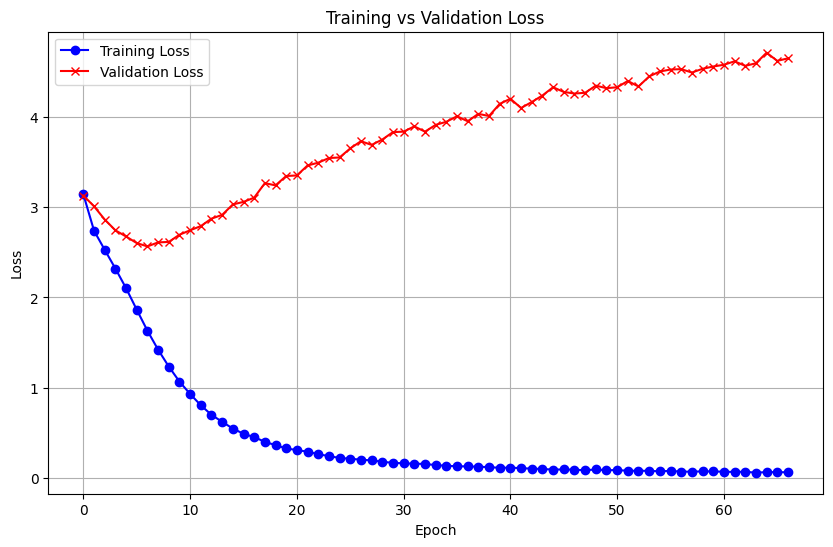

In [8]:
model = CNN_MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
model.to(device)

trained_model , train_loss , val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device=device)
plot(train_loss,val_loss)
